# Udacity Self-Driving Car NanoDegree Course
## Vehicle Detection Project

The goals/steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of colors, to your HOG features vector
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detection frame by frame to reject outliers and follow detected vehicles.
* Extimate a bounding box for vehicles detected.

### Histogram of Oriented Gradients(HOG)


* Explain how you extracted HOG features from the training images

By using the skimage.feature.hog function, we can get the hog features for the images. Also we should consider the the color space and channels which give us more apparent HOG features, after the comparison, I've decided to use the YUV color space, and all the three channels.

The code snippnet is as following:

In [1]:
# We'll still use the same one from the online course materials
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    # Call with two outputs if vis == True
    if vis == True:
        features, hog_image = hog(img,orientations=orient,pixels_per_cell = (pix_per_cell,pix_per_cell),cells_per_block=(cell_per_block,cell_per_block),transform_sqrt=False,visualise=vis,feature_vector=feature_vec)
        return features,hog_image
    # otherwise call with one output
    else:
        features = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell),cells_per_block = (cell_per_block,cell_per_block),transform_sqrt= False,visualise=vis,feature_vector=feature_vec)
        return features

print("HOG function Done!")
    

# Extract the HOG features from the list of images
# This function could also be usedto call bin_spatial() and color_hist() to extract flattened spatial color features
# and color histogram features and combine them all to be used together for classification

def extract_features(imgs,cspace='RGB',orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=0):
    
    # Create a list to append feature vectors 
    features = []
    
    # iterate through the list of images
    for img_name in imgs:
        # read in each one by one
        image = mpimg.imread(img_name)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
            
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],orient,pix_per_cell,cell_per_block,vis=Fasle,feature_vec=True)
        
        features.append(hog_features)
    
    return features

print('Extract HOG features Function Done!')

HOG function Done!
Extract HOG features Function Done!


* Explain how you settled on your final choice of HOG parameters

The parameters selection is chosen based on the performance of the different combination, then the parameters are listed as following,orient = 9, pixels_per_cell = (8,8),cells_per_block = (8,8).

Here, the different color spaces have been explored for the HOG features extraction, included 'RGB','HSV','LUV','HLS','YUV','YCrCb'. Below are example for the B channels for HOG features for the car and noncar image with the parameter for the HOG function, orient = 9, pixels_per_cell = (8,8),cells_per_block = (8,8).
![02_HOG_car_and_noncar.png](attachment:02_HOG_car_and_noncar.png)


First I define the function to detect the HOG features for the cars images, then define an function named extract_features() to consider more parameters for the image feature extraction. But before that, the most important thing is to visualise the dataset for car and noncar images, like below:
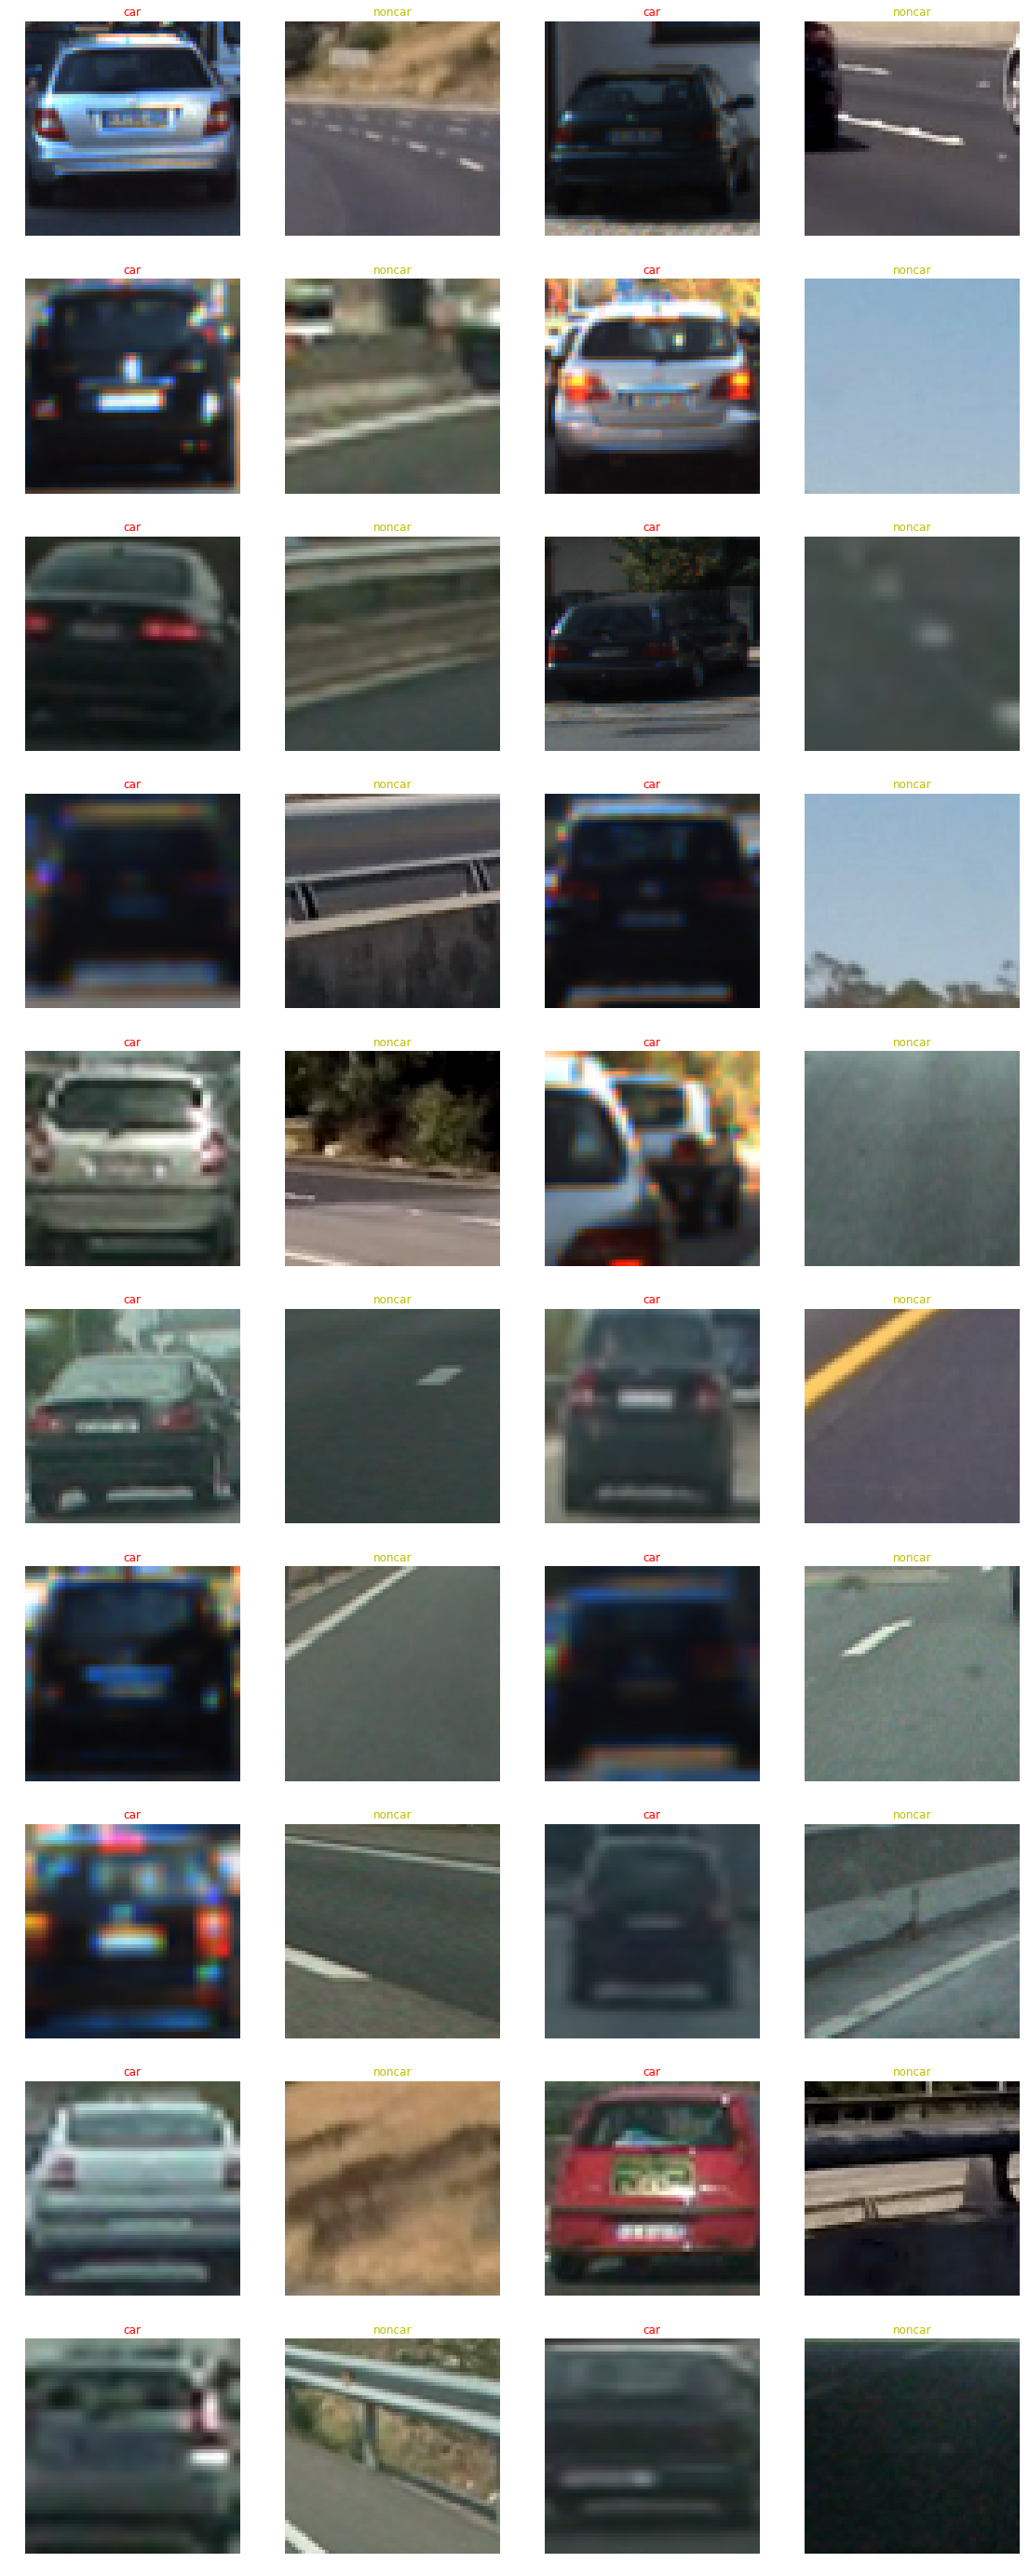



* Describe how you trained a classifier using your selected HOG features

I am training a linear SVM using the HOG features, the color space is 'YUV', the orient = 11, pix_per_cell = 16, cell_per_block = 2, hog_channel = 'ALL'. First I split the dataset for (train,test) = (80%,20%) with the train_test_split function from sklearn.model_selection. For each image, I could a feature vector with length of 1188. After the training, I can get a linear SVM classifier with an accuracy of 98.11%. The code snippit is as below: 

In [ ]:
# The parameters for feature extraction 
colorspace = 'YUV' # can be RGB,HSV,LUV,HLS,ETC
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # can be 0,1,2,all

t1 = time.time()
car_features = extract_features(car_images,cspace=colorspace,orient=orient,pix_per_cell = pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel)

notcar_features = extract_features(noncar_images,cspace=colorspace,orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel)

t2 = time.time()
print('The features extraction has consumed about {} seconds'.format(round(t2-t1,2)))


# Create an array stack of feature vectors
x = np.vstack((car_features,notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))


# split up date into randomized training and test sets
rand_state = np.random.randint(0,100)

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=rand_state)

print('Feature length:',len(X_train[0]))



# Use a linear SVC from sklearn
svc = LinearSVC()

t1 = time.time()
svc.fit(X_train,y_train)
t2 = time.time()
print('Training SVC consumes {} seconds'.format(round(t2-t1,2)))

# Check the score of the SVC
svc_score = svc.score(X_test,y_test)
print('Test Accuracy of SVC = ',round(svc_score,4))


### Sliding Window Search

* Describe how you implemented a sliding window search. How did you decide what scales to search and how much to overlap window?

All this method is referred from the onlince course where the sliding window is mentioned. We're using the horizitally sliding window for the HOG features of the car which is trained in linear SVM classifier. For the scale parameter, first I used the scale = 1 then check the box circled around the car in the image, and tried several ones for different sizes of the cars due to their distance away from the camera. And then set a few scale parameters for the selection of the boxes. In term of the overlap of the window, here I am using the cells_per_step parameters to indicate the step length for the sliding windows(referred to the https://github.com/jeremy-shannon).

The code snippit is as following:

In [3]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            hog_features = hog_features.ravel().reshape(1,-1)
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

# Define the draw function onto an image
def draw_boxes(img,bboxes,color=(0,0,255),thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    random_color = False
    # Draw all the boxes from the list onto the image
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img,bbox[0],bbox[1],color,thick)
    return draw_img

I've tested this function on the test_image, and the results are shown below.
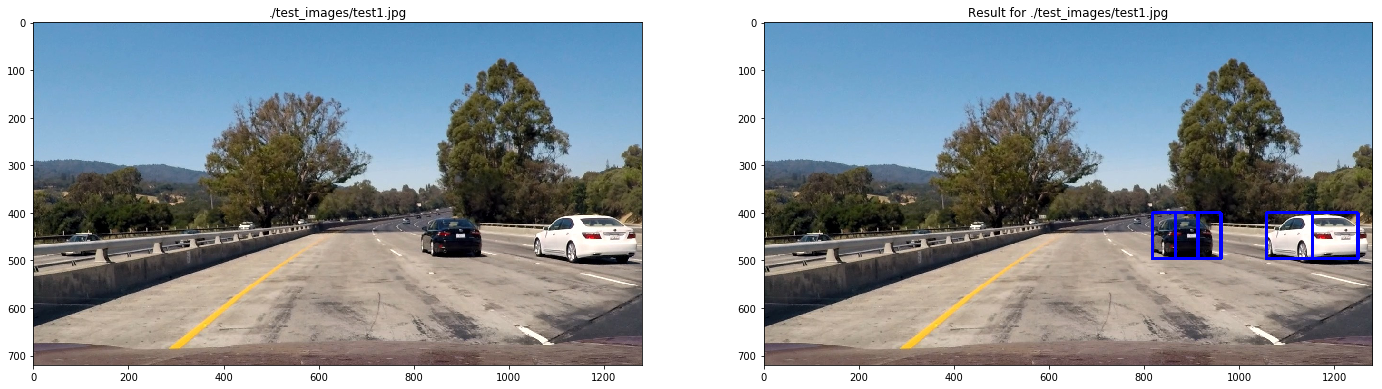
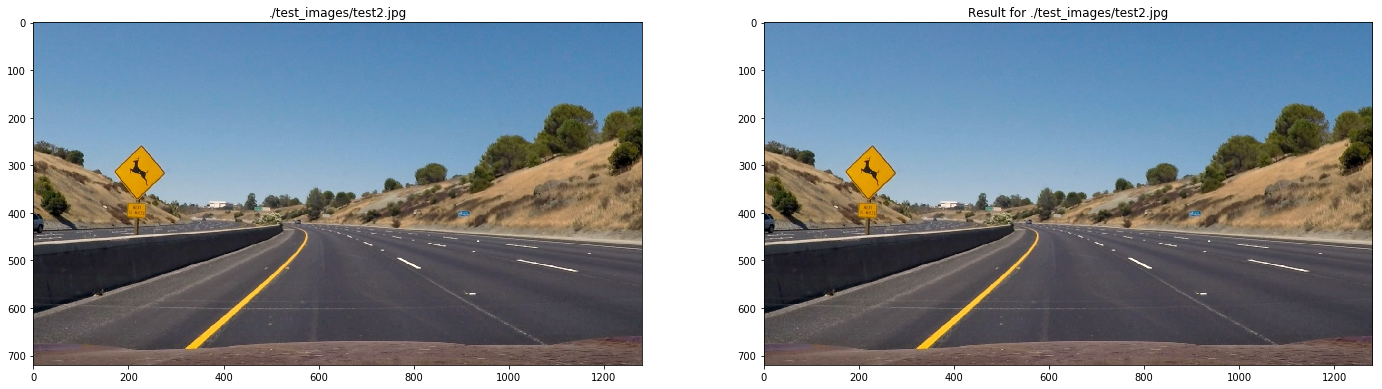
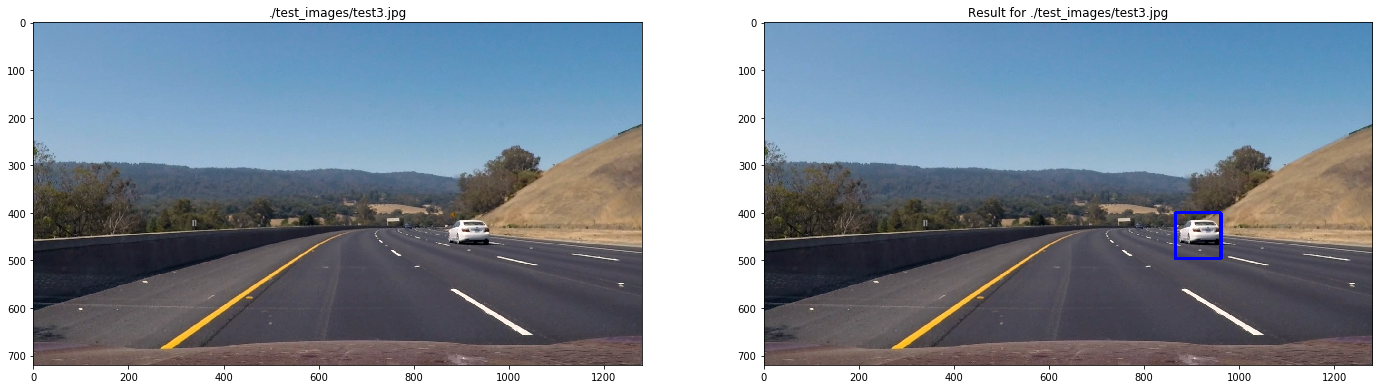
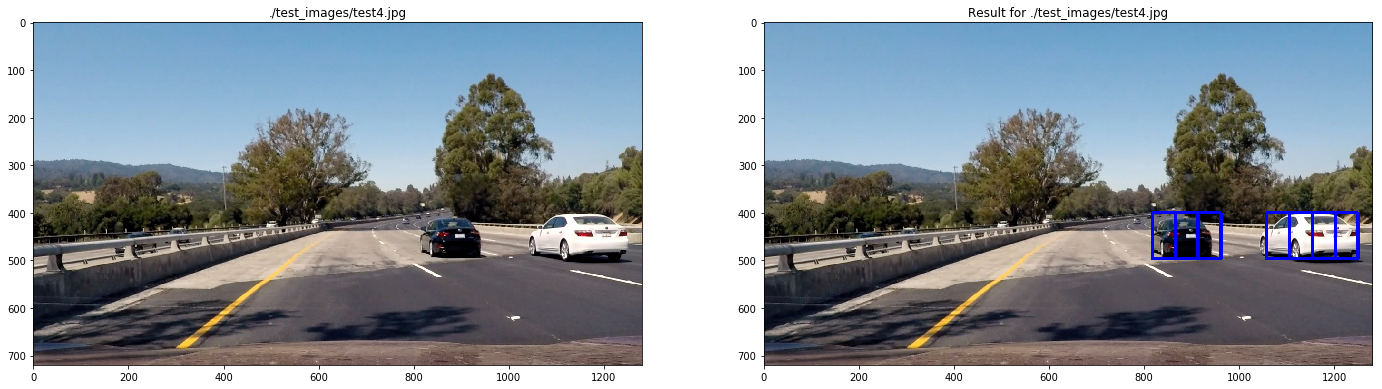
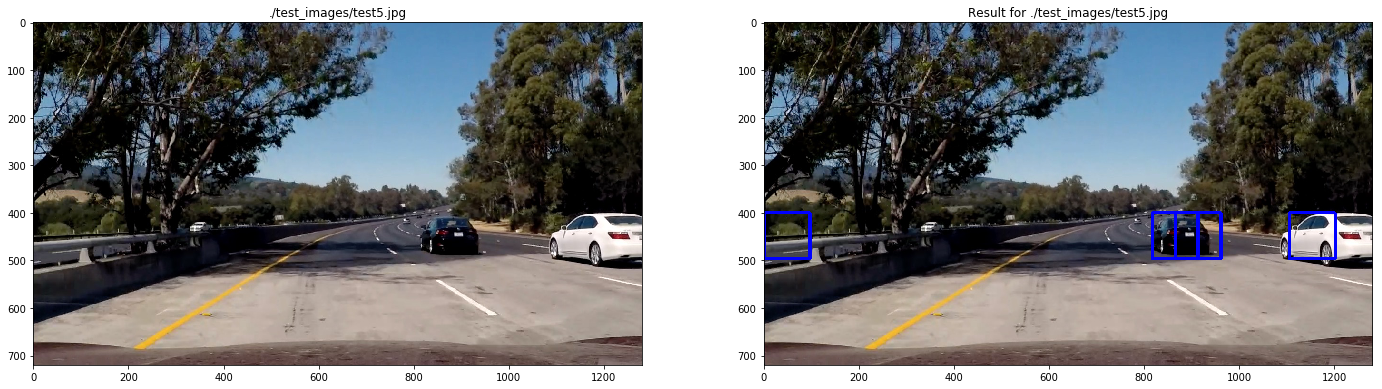
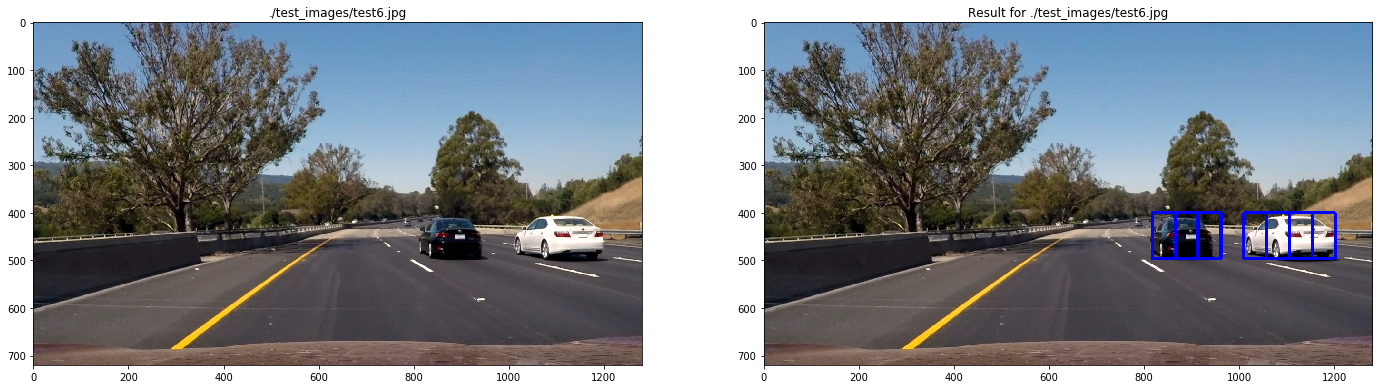

* Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?

As shown in the last section and the below figure(with multiple boxes), we can see some defects in this SVM classifier. Nagtive positive and recurring detections for the same car object.

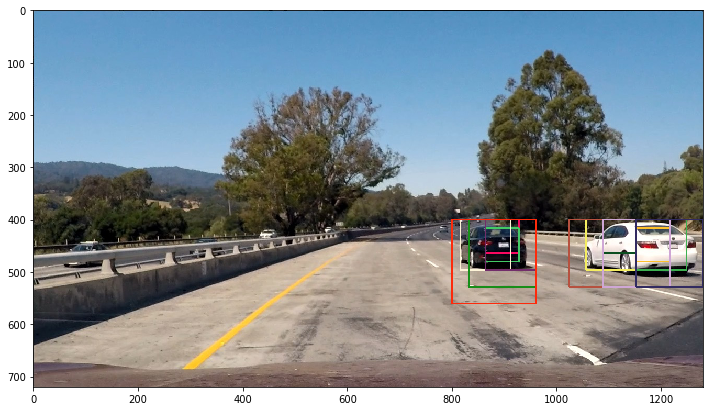


So here we use the heatmap tech and apply a suitable threshold to eliminate these problems, the corresponding code snippits are shown here.

In [ ]:
def heat_map(img,bbox_list):
    # Create the heatmap
    heatmap = np.zeros_like(img[:,:,0])
    # Iterate through list of the bboxes
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap,threshold):
    heatmap[heatmap<= threshold] = 0
    return heatmap

labels = label(heatmap_img)


def pipeline_car(img):
    # Create the list to store the bboxes
    rectangles = []
    

    colorspace = 'YUV' 
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'
    # Get the first set of parameters considering the size and positions of the cars
    ystart,ystop,scale = Parameter(0,0,0)
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))
    # Get the second set of parameters considering the size and positions of the cars in the test image
    ystart,ystop,scale = Parameter(16,16,0)
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the third set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(0,32,0.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))


    # Get the sforth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(32,64,0.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))


    # Get the fifth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(0,64,1.0)
    
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the sixth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(32,96,1.0)
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the seventh set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(0,96,2.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the eighth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(64,160,2.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the ninth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(16,80,1.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))


    # Get the tenth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(64,128,1.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the 11th set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(0,128,1.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))
    
    # Get the tenth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(32,160,1.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))



    rectangles = [item for sublist in rectangles for item in sublist]
    

    heatmap_img = heat_map(img,rectangles)

    heatmap_img = apply_threshold(heatmap_img,threshold = 1)

    labels = label(heatmap_img)

    draw_img,rects = draw_labeled_bboxes(np.copy(img),labels)
    

    return draw_img

The output for heat_map, heatmap_with_threshold,label() and the final results are shown as below.
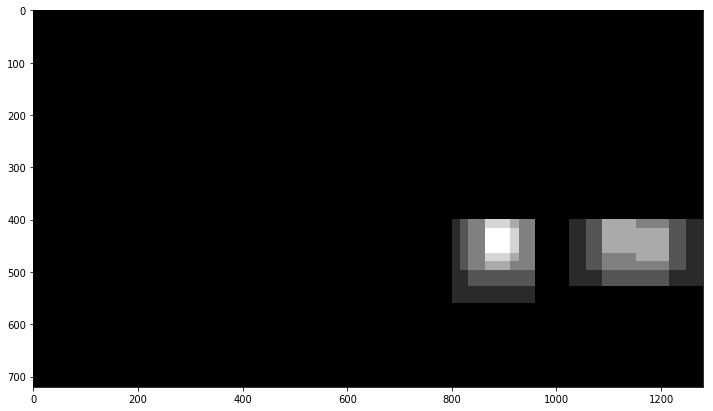
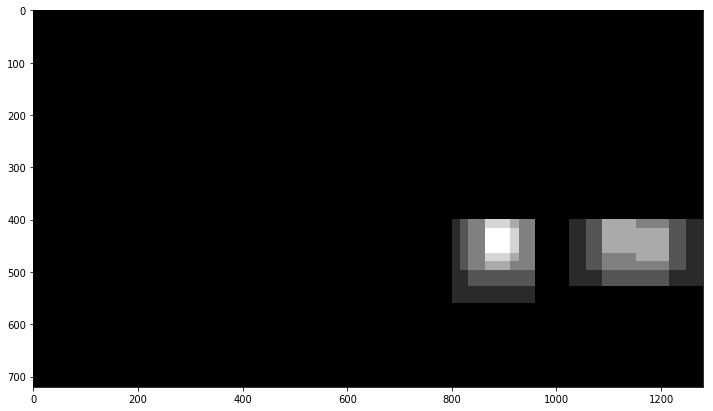
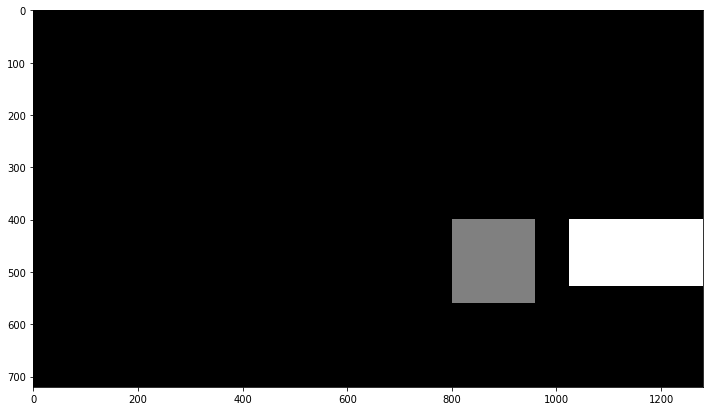
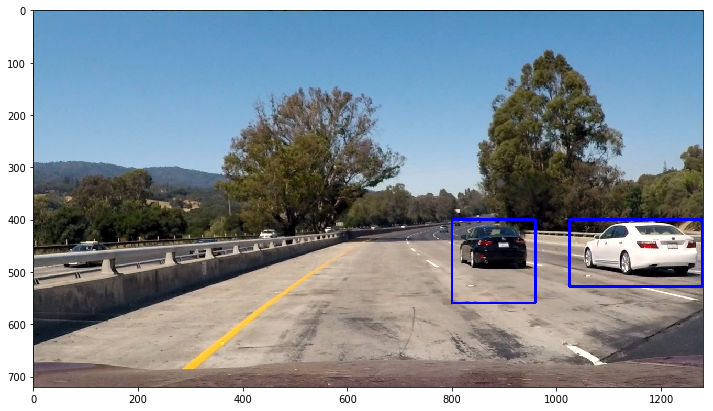
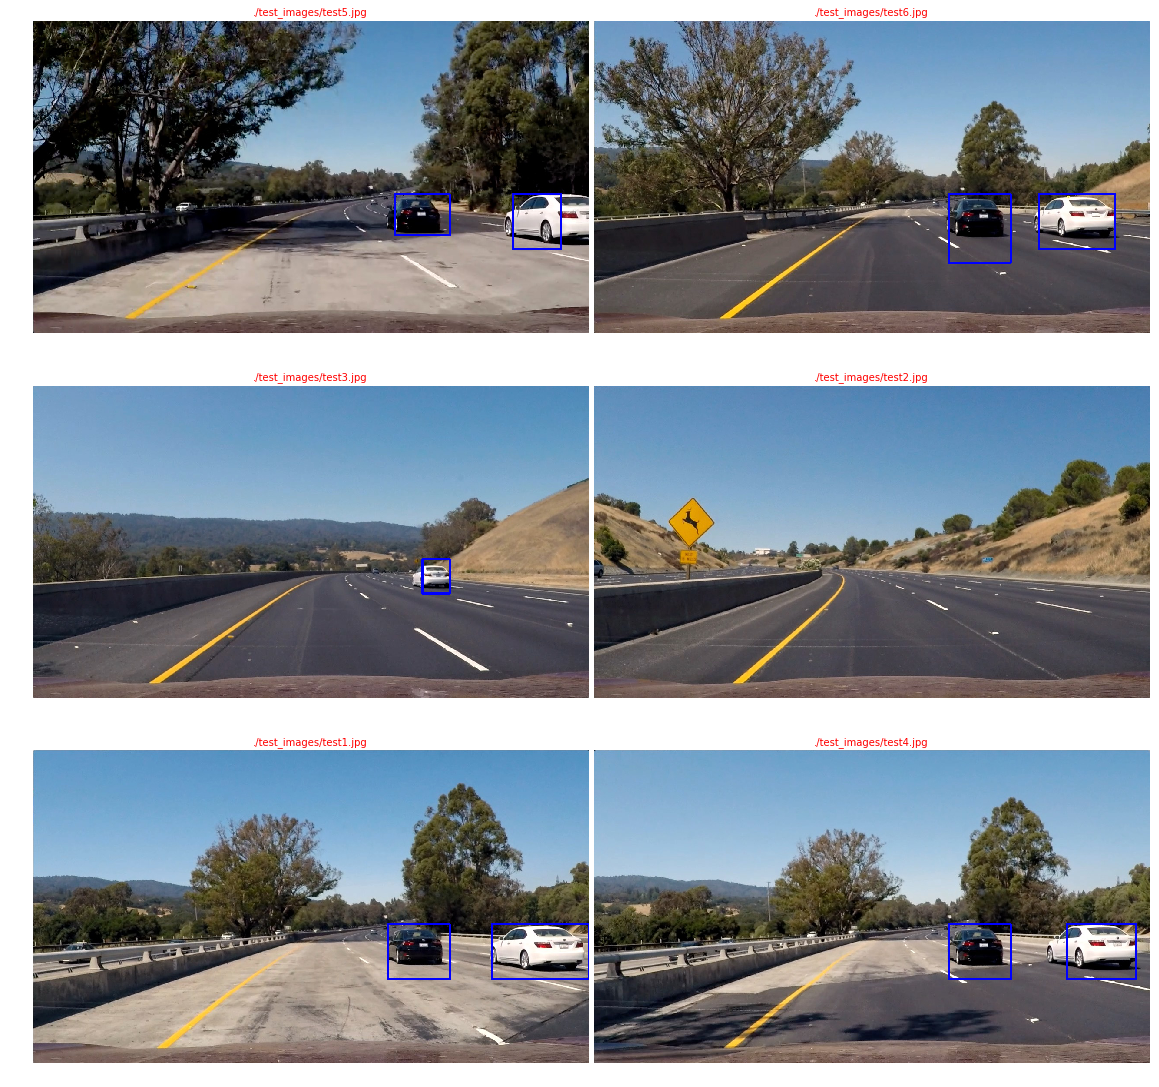

### Video Implementation

* Provide a link to your final video output.
The ouput video for the test_video.mp4, project_video.mp4, project_video_output.mp4 (the output from Advanced Lane Line detection Project) are zipped into the same file.

* For the false positive and recurring detection problems
I've talked about these issues and the corresponding method before. heatmap with threshold can reduce the false positive and recurring detection problem very well thank to the materials provided in the online course.


### Discussion

Here I just use HOG features to detect the car in the image and video, sometimes the performance is not so good. For example, in the first output video, we can see that the detection box for the white car is not so good just having an 50% area are in the bounding boxs. We could improve thise kind of performance with more sized sliding windows.

In the future, I could try to include the color features and histograms into this feature detections function or try to use the DNN method to train a more suitable classifier for the car detection and tracking. 